# Outlier Detection in Regression Using Cook's Distance
> Use of Housing price data for outlier detection

In [7]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

In [3]:
house_df = pd.read_csv('house_prices_dataset.csv')
house_df

Id                       MSSubClass                 MSZoning  LotArea  \
0        1             2-Story 1946 & Newer  Residential Low Density     8450   
1        2  1-Story 1946 & Newer All Styles  Residential Low Density     9600   
2        3             2-Story 1946 & Newer  Residential Low Density    11250   
3        4             2-Story 1945 & Older  Residential Low Density     9550   
4        5             2-Story 1946 & Newer  Residential Low Density    14260   
...    ...                              ...                      ...      ...   
1455  1456             2-Story 1946 & Newer  Residential Low Density     7917   
1456  1457  1-Story 1946 & Newer All Styles  Residential Low Density    13175   
1457  1458             2-Story 1945 & Older  Residential Low Density     9042   
1458  1459  1-Story 1946 & Newer All Styles  Residential Low Density     9717   
1459  1460  1-Story 1946 & Newer All Styles  Residential Low Density     9937   

     Street            LotShape      LandContour  \
0     Paved             Regular  Near Flat/Level   
1     Paved             Regular  Near Flat/Level   
2     Paved  Slightly irregular  Near Flat/Level   
3     Paved  Slightly irregular  Near Flat/Level   
4     Paved  Slightly irregular  Near Flat/Level   
...     ...                 ...              ...   
1455  Paved             Regular  Near Flat/Level   
1456  Paved             Regular  Near Flat/Level   
1457  Paved             Regular  Near Flat/Level   
1458  Paved             Regular  Near Flat/Level   
1459  Paved             Regular  Near Flat/Level   

                             Utilities                        LotConfig  \
0     All public Utilities (E,G,W,& S)                       Inside lot   
1     All public Utilities (E,G,W,& S)  Frontage on 2 sides of property   
2     All public Utilities (E,G,W,& S)                       Inside lot   
3     All public Utilities (E,G,W,& S)                       Corner lot   
4     All public Utilities (E,G,W,& S)  Frontage on 2 sides of property   
...                                ...                              ...   
1455  All public Utilities (E,G,W,& S)                       Inside lot   
1456  All public Utilities (E,G,W,& S)                       Inside lot   
1457  All public Utilities (E,G,W,& S)                       Inside lot   
1458  All public Utilities (E,G,W,& S)                       Inside lot   
1459  All public Utilities (E,G,W,& S)                       Inside lot   

         LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal  \
0     Gentle slope  ...             0         0           0        0       0   
1     Gentle slope  ...             0         0           0        0       0   
2     Gentle slope  ...             0         0           0        0       0   
3     Gentle slope  ...           272         0           0        0       0   
4     Gentle slope  ...             0         0           0        0       0   
...            ...  ...           ...       ...         ...      ...     ...   
1455  Gentle slope  ...             0         0           0        0       0   
1456  Gentle slope  ...             0         0           0        0       0   
1457  Gentle slope  ...             0         0           0        0    2500   
1458  Gentle slope  ...           112         0           0        0       0   
1459  Gentle slope  ...             0         0           0        0       0   

      MoSold  YrSold                      SaleType  SaleCondition SalePrice  
0          2    2008  Warranty Deed - Conventional    Normal Sale    208500  
1          5    2007  Warranty Deed - Conventional    Normal Sale    181500  
2          9    2008  Warranty Deed - Conventional    Normal Sale    223500  
3          2    2006  Warranty Deed - Conventional  Abnormal Sale    140000  
4         12    2008  Warranty Deed - Conventional    Normal Sale    250000  
...      ...     ...                           ...            ...       ...  
14

In [5]:
predictors = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 
              'YearBuilt', 'FullBath',	'HalfBath', 'GarageArea']
target = 'SalePrice'

In [1]:
# from category_encoders import OrdinalEncoder

# X_df=house_df[house_df.columns.difference(['SalePrice'])]
# categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

# encoder = OrdinalEncoder(
#     cols=categorical_features,
#     handle_unknown='ignore',
#     return_df=True).fit(X_df)

# X_df=encoder.transform(X_df)
# X_df = pd.concat([X_df,house_df['SalePrice']], axis=1)

# Using Scikit-Learn

In [6]:
house_lm = LinearRegression()
house_lm.fit(house_df[predictors], house_df[target])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -813660.155
Coefficients:
 OverallQual: 21135.208220261473
 GrLivArea: 55.108315659107156
 TotalBsmtSF: 26.215600329952718
 YearBuilt: 375.99279986319704
 FullBath: -4817.261439026484
 HalfBath: -1754.2880796739735
 GarageArea: 45.37986566776556


In [35]:
fitted = house_lm.predict(X_df[predictors])
RMSE = np.sqrt(mean_squared_error(X_df[target], fitted))
r2 = r2_score(X_df[target], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 38320
r2: 0.7672


# Using Statsmodels

In [36]:
model = sm.OLS(X_df[target], X_df[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     683.5
Date:                Wed, 21 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:37:27   Log-Likelihood:                -17480.
No. Observations:                1460   AIC:                         3.498e+04
Df Residuals:                    1452   BIC:                         3.502e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
OverallQual  2.114e+04   1151.421     18.356      

# Outlier analysis

In [38]:
influence = OLSInfluence(house_outlier)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

1298 -14.470612477134905


In [39]:
outlier = X_df.loc[sresiduals.idxmin(), :]
print('SalePrice', outlier[target])
print(outlier[predictors])

SalePrice 160000
OverallQual      10
GrLivArea      5642
TotalBsmtSF    6110
YearBuilt      2008
FullBath          2
HalfBath          1
GarageArea     1418
Name: 1298, dtype: object


In [125]:
data = pd.DataFrame(columns = ['Id', 'X', 'Y', 'YearBuilt', 'OverallQual','Dist'])
data['Id'] = X_df.Id
data['X'] = influence.hat_matrix_diag
data['Y'] = influence.resid_studentized_internal
data['YearBuilt'] = X_df["YearBuilt"]
data['Dist'] = influence.cooks_distance[0]
fig = px.scatter(data, x='X', y='Y', hover_data = ["Id","YearBuilt"])
fig.show()

In [126]:
data

Id         X         Y  YearBuilt OverallQual          Dist
0        1  0.002744 -0.235977       2003         NaN  1.915350e-05
1        2  0.002918  0.300141       1976         NaN  3.295641e-05
2        3  0.002532 -0.049297       2001         NaN  7.710510e-07
3        4  0.010102 -1.388130       1915         NaN  2.458094e-03
4        5  0.003920 -0.915279       2000         NaN  4.120890e-04
...    ...       ...       ...        ...         ...           ...
1455  1456  0.003141 -0.390814       1999         NaN  6.016582e-05
1456  1457  0.004052 -0.380320       1978         NaN  7.356183e-05
1457  1458  0.007588  1.083008       1941         NaN  1.120971e-03
1458  1459  0.002315  0.604003       1950         NaN  1.058183e-04
1459  1460  0.005436  0.223434       1965         NaN  3.410932e-05

[1460 rows x 6 columns]

In [148]:
data['Dist']

0       1.915350e-05
1       3.295641e-05
2       7.710510e-07
3       2.458094e-03
4       4.120890e-04
            ...     
1455    6.016582e-05
1456    7.356183e-05
1457    1.120971e-03
1458    1.058183e-04
1459    3.410932e-05
Name: Dist, Length: 1460, dtype: float64

In [146]:
data['Dist'].max()

4.131965447174376

In [150]:
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks

cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import pandas as pd
from sklearn.datasets import load_boston

data.iplot(
    x='X',
    y='Y',
    size=data['Dist']*10, 
    text='Dist',
    mode='markers',
    layout=dict(
        xaxis=dict(title='Id'),
        yaxis=dict(title='Studentized residuals'),
        title="Id vs Studentized residuals sized by Cook's Distance"))


In [142]:
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks

cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import pandas as pd
from sklearn.datasets import load_boston

data.iplot(
    x='X',
    y='Y',
    size=data['Dist']*50, 
    text='Dist',
    mode='markers',
    layout=dict(
        xaxis=dict(title='Id'),
        yaxis=dict(title='Studentized residuals'),
        title="Id vs Studentized residuals sized by Cook's Distance"))


In [104]:
import plotly.graph_objects as go

N = 100000
fig = go.Figure(data=go.Scattergl(
    x = influence.hat_matrix_diag,
    y = influence.resid_studentized_internal,
    mode='markers',
    marker=dict(
        color=np.random.randn(N),
        colorscale='Viridis',
        line_width=1
    )
))

fig.show()

In [89]:
# Compute the influence to get Cook's distance
influence = OLSInfluence(house_outlier)

# cooks_distance is an attribute of incluence, here C, not sure about P (p-value maybe?)
C = influence.cooks_distance[0]

Text(0, 0.5, "Cook's Distance")

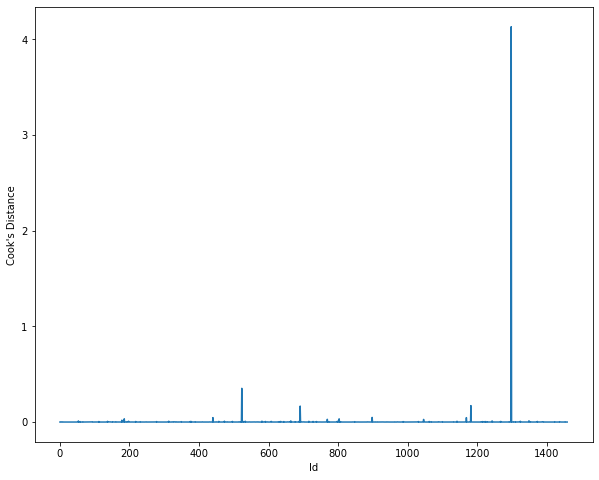

In [83]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(C)
plt.xlabel('Id')
plt.ylabel("Cook's Distance")

In [149]:
import plotly.express as px

Cook = pd.DataFrame(columns = ['Id', "Cook_'s Distance"])
Cook['Id'] = X_df.Id
Cook["Cook's Distance"] = C
fig = px.line(Cook, x="Id", y="Cook's Distance", title = "Cook's Distance")
fig.show()